In [1]:
import torch
from eva.core.models.wrappers import _utils
from eva.vision.callbacks.loggers.batch.segmentation import _draw_semantic_mask, _overlay_mask
import matplotlib.pyplot as plt
from torch.nn import functional
from eva.core import metrics
from lightning_fabric.utilities import cloud_io
from eva.vision.models.networks.decoders.segmentation import ConvDecoderMS, PVTFormerDecoder
from eva.vision.models import modules, wrappers
from eva.vision.models.networks import adapters
from collections import defaultdict
import pandas as pd
from monai import metrics as monai_metrics
import wandb
import os

2024-09-10 15:43:17.387 | WARNING  | eva.vision.models.networks.adapters.vit_adapter._ms_deform_attn_func:<module>:23 - MultiScaleDeformableAttention CUDA op not found. Running on CPU.


## Load Model

In [2]:
HF_TOKEN = "" # TODO: set huggingface token

### Download trained models

We compare convdecoderms v.s. vit-adapater + pvtformer using UNI as a backbone.

In [3]:
DOWNLOAD_DIR = '/tmp/eva'

api = wandb.Api()
artifact = api.artifact("radiology_dev/vit-adapter-experiments/model-j8iuamxn:v1", type='model')
local_dir = artifact.download(root=os.path.join(DOWNLOAD_DIR, "convdecoderms"))
checkpoint_path_1 = os.path.join(local_dir, "model.ckpt")

assert os.path.exists(checkpoint_path_1), f"Checkpoint not found at {checkpoint_path_1}"

artifact = api.artifact("radiology_dev/vit-adapter-experiments/model-l0bkpqjt:v1", type='model')
local_dir = artifact.download(root=os.path.join(DOWNLOAD_DIR, "adapter_pvtformer"))
checkpoint_path_2 = os.path.join(local_dir, "model.ckpt")

assert os.path.exists(checkpoint_path_2), f"Checkpoint not found at {checkpoint_path_2}"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Downloading large artifact model-j8iuamxn:v1, 1164.12MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3
wandb: Downloading large artifact model-l0bkpqjt:v1, 1290.40MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:9.0


In [4]:
# checkpoint_path_1 = "/mnt/localdisk/data/eva/models/consep/uni_convdecoder.ckpt"
model_1 = modules.SemanticSegmentationModule(
    encoder=wrappers.ModelFromRegistry(
        model_name="pathology/mahmood_uni",
        model_kwargs={"out_indices": 1, "hf_token": HF_TOKEN}
    ),
    decoder=ConvDecoderMS(in_features=1024, num_classes=5),
    criterion=None
)

checkpoint = torch.load(checkpoint_path_1, map_location="cpu")
model_1.load_state_dict(checkpoint['state_dict'])

_ = model_1.eval()

In [5]:
# checkpoint_path = "/mnt/localdisk/data/eva/models/consep/uni_adapter_pvtformer_last.ckpt"
model_name = "pathology/mahmood_uni"
model_2 = modules.SemanticSegmentationModule(
    encoder=adapters.ViTAdapter(
        vit_backbone=wrappers.ModelFromRegistry(
                model_name=model_name,
                model_kwargs={"hf_token": HF_TOKEN}
        ),
        deform_num_heads=8,
        freeze_vit=True
    ),
    decoder=PVTFormerDecoder(in_features=[1024]*3, num_classes=5),
    criterion=None
)

checkpoint = torch.load(checkpoint_path_2)
model_2.load_state_dict(checkpoint['state_dict'])

_ = model_2.eval()

2024-09-10 15:43:37.853 | INFO     | eva.vision.models.networks.adapters.vit_adapter.vit_adapter:_calculate_interactions:131 - Using interactions at [[0, 5], [6, 11], [12, 17], [18, 23]] for 24 blocks.


## Load Data

In [6]:
from eva.vision import datasets
from eva.vision.data.wsi.patching import samplers
from eva.vision.data import transforms

dataset = datasets.CoNSeP(
    # root="/mnt/localdisk/data/datasets/consep",
    root="/mnt/localdisk/data/consep",
    split="val",
    sampler=samplers.ForegroundGridSampler(max_samples=25),
    transforms=transforms.ResizeAndCrop(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms=transforms.ResizeAndCrop(size=224, mean=[0.5]*3, std=[0.5]*3)
)
dataset.configure()

image, target, metadata = dataset[0]
image.shape

2024-09-10 15:43:39.548 | INFO     | eva.vision.data.datasets.wsi:_load_datasets:163 - Initializing dataset with 14 WSIs ...


torch.Size([3, 224, 224])

/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction 

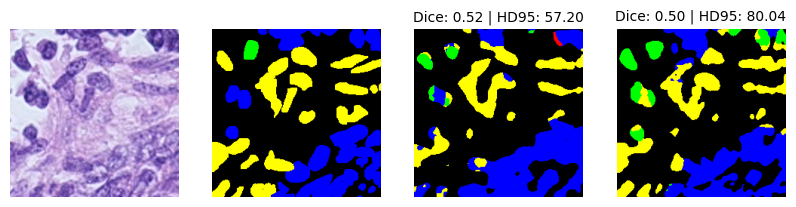

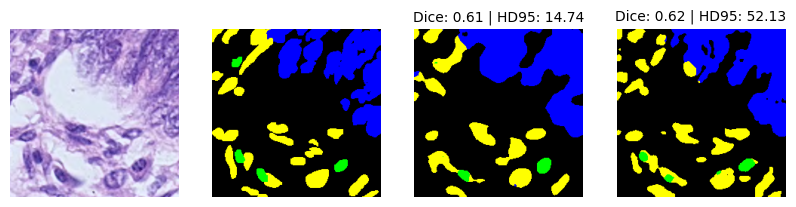

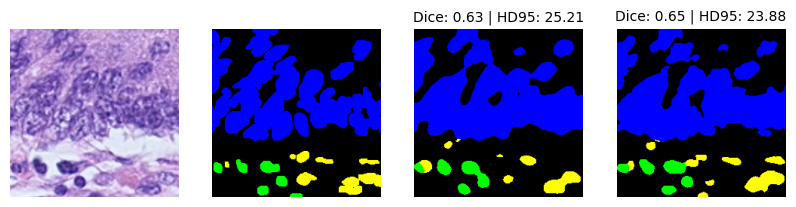

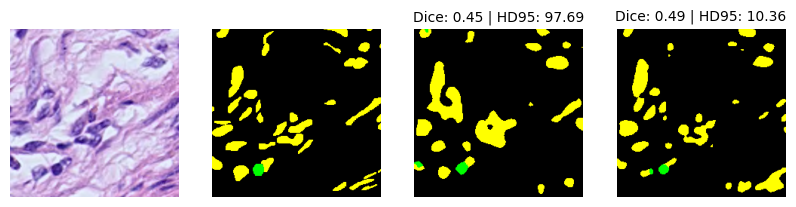

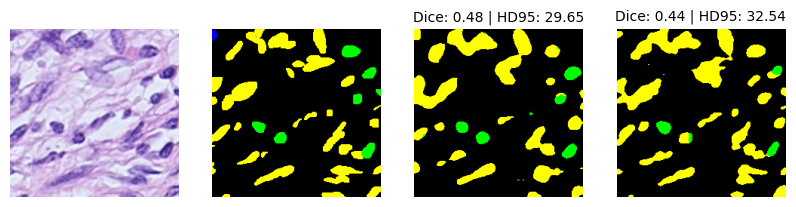

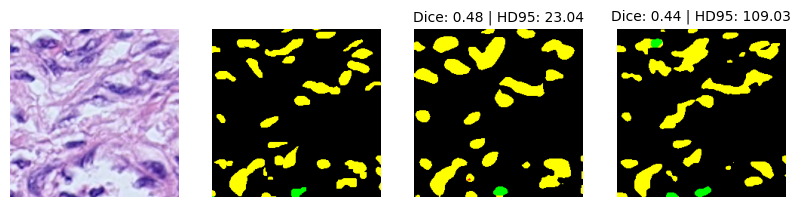

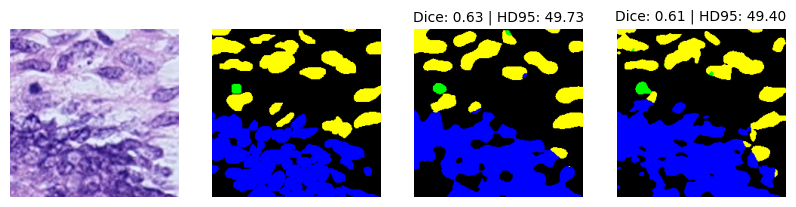

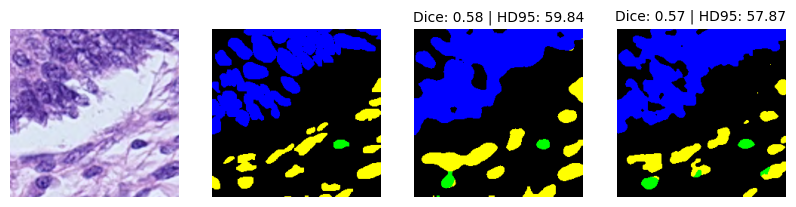

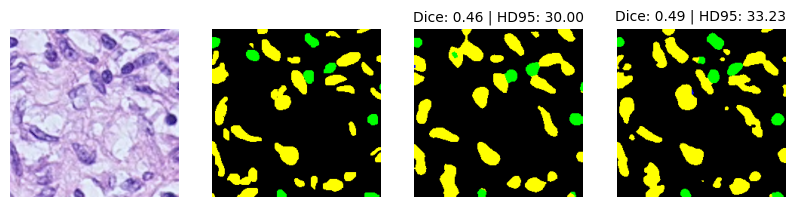

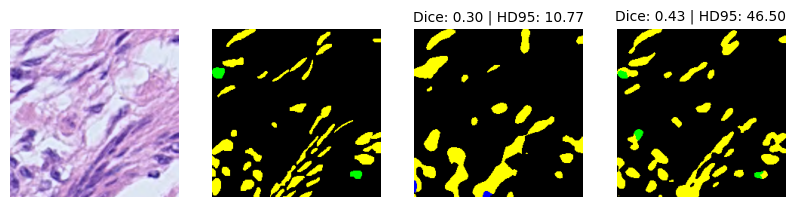

In [10]:
N_IMAGES = 10
MODELS = [model_1, model_2]

dice_metric = metrics.GeneralizedDiceScore(num_classes=5, input_format="index", weight_type="linear", per_class=False, include_background=False)

def _preprocess_image(image: torch.Tensor):
    image = image - image.min()
    image = image / image.max()
    return image

def _one_hot(tensor: torch.Tensor, num_classes: int=5):
    return functional.one_hot(tensor, num_classes=5).permute(2, 0, 1)

for i in range(N_IMAGES):
    image, target, metadata = dataset[i]

    fig, ax = plt.subplots(1, 2 + len(MODELS), figsize=(10, 3))
    for j, model in enumerate(MODELS):
        prediction = model(image.unsqueeze(0), to_size=(224, 224))
        prediction = torch.argmax(prediction, dim=1)

        image_normalized = _preprocess_image(image.clone())
        image_with_mask = _overlay_mask(image_normalized, prediction.squeeze())

        fig.axes[0].imshow(image_normalized.permute(1, 2, 0))
        fig.axes[1].imshow(_draw_semantic_mask(target).permute(1, 2, 0))
        fig.axes[2+j].imshow(_draw_semantic_mask(prediction).permute(1, 2, 0))

        dice_value = dice_metric(_one_hot(prediction.squeeze()), _one_hot(target))
        hd95_value = monai_metrics.compute_hausdorff_distance(_one_hot(prediction.squeeze()).unsqueeze(0), _one_hot(target).unsqueeze(0), percentile=95)
        hd95_value = hd95_value.nanmean()

        fig.axes[2+j].set_title(f"Dice: {dice_value:.2f} | HD95: {hd95_value:.2f}", fontsize=10)

        for ax in fig.axes:
            ax.axis('off')

## Analyze scores

In [11]:
import tqdm
results_dict = defaultdict(list)

for i in tqdm.tqdm(range(len(dataset))):
# for i in tqdm.tqdm(range(10)):
    image, target, metadata = dataset[i]

    for j, model in enumerate(MODELS):
        prediction = model(image.unsqueeze(0), to_size=(224, 224))
        prediction = torch.argmax(prediction, dim=1)
        dice_value = dice_metric(_one_hot(prediction.squeeze()), _one_hot(target))
        hd95_value = monai_metrics.compute_hausdorff_distance(_one_hot(prediction.squeeze()).unsqueeze(0), _one_hot(target).unsqueeze(0), percentile=95)
        hd95_value = hd95_value.nanmean()

        model_name = str(model.decoder.__class__).split(".")[-1].strip("'>")
        results_dict[f"Dice ({model_name})"].append(dice_value.item())
        results_dict[f"HD95 ({model_name})"].append(hd95_value.item())

        if j == 0:
            results_dict["index"].append(i)
            results_dict["file"].append(dataset.filename(i))

  5%|▍         | 10/222 [00:06<02:22,  1.49it/s]/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
 14%|█▍        | 32/222 [00:21<02:08,  1.48it/s]/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 3 is all 0, this may result in nan/inf distance.
  warnings.warn(
 15%|█▌        | 34/222 [00:22<02:08,  1.47it/s]/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 3 is all 0, this may result in nan/inf distance.
  warnings.warn(
100%|██████████| 222/222 [02:27<00:00,  1.50it/s]


In [13]:
df_results = pd.DataFrame(results_dict)

df_results.head(5)

,Dice (ConvDecoderMS),HD95 (ConvDecoderMS),index,file,Dice (PVTFormerDecoder),HD95 (PVTFormerDecoder)
0,0.524965,57.200226,0,test_1.png,0.503329,80.036011
1,0.609199,14.737599,1,test_1.png,0.622541,52.134205
2,0.629114,25.206156,2,test_1.png,0.645922,23.883657
3,0.452214,97.693886,3,test_1.png,0.485557,10.356884
4,0.476051,29.648611,4,test_1.png,0.441178,32.536865


In [14]:
df_results.describe()

,Dice (ConvDecoderMS),HD95 (ConvDecoderMS),index,Dice (PVTFormerDecoder),HD95 (PVTFormerDecoder)
count,222.000000,219.000000,222.000000,222.000000,218.000000
mean,0.429410,44.528395,110.500000,0.427210,52.089478
std,0.094005,34.592807,64.230055,0.097024,35.689204
min,0.199804,4.242640,0.000000,0.199244,3.413594
25%,0.346134,19.874905,55.250000,0.347769,23.720198
50%,0.442150,32.129543,110.500000,0.434989,42.940704
75%,0.482156,61.334196,165.750000,0.488260,79.718573
max,0.667326,227.404373,221.000000,0.647571,229.349945


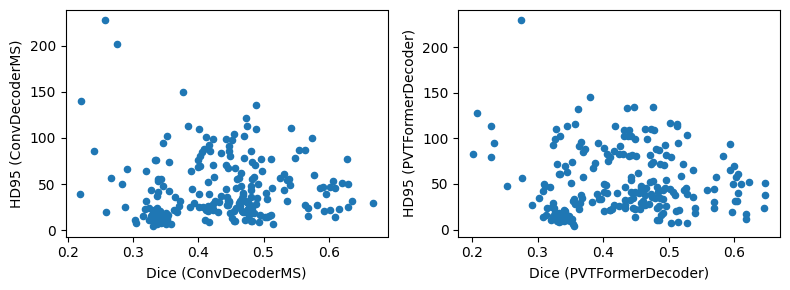

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
df_results.plot.scatter(x="Dice (ConvDecoderMS)", y="HD95 (ConvDecoderMS)", ax=axs[0])
df_results.plot.scatter(x="Dice (PVTFormerDecoder)", y="HD95 (PVTFormerDecoder)", ax=axs[1])

plt.tight_layout()

### Visualize samples where ConvDecoderMS is better than PVTFormerDecoder

In [17]:
conv_better_dice_filter = df_results["Dice (ConvDecoderMS)"] > df_results["Dice (PVTFormerDecoder)"]
conv_better_hd95_filter = df_results["HD95 (ConvDecoderMS)"] < df_results["HD95 (PVTFormerDecoder)"]
print(conv_better_dice_filter.sum(), len(df_results))
print(conv_better_hd95_filter.sum(), len(df_results))
print((conv_better_dice_filter & conv_better_hd95_filter).sum(), len(df_results))

df_results["Dice (diff)"] = df_results["Dice (ConvDecoderMS)"] - df_results["Dice (PVTFormerDecoder)"]
df_results["HD95 (diff)"] = df_results["HD95 (ConvDecoderMS)"] - df_results["HD95 (PVTFormerDecoder)"]
df_results_conv_better = df_results[conv_better_dice_filter].sort_values("Dice (diff)", ascending=False).copy()

130 222
137 222
82 222


/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:334: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/metrics/utils.py:329: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/home/azureuser/eva/.venv/lib/python3.12/site-packages/monai/met

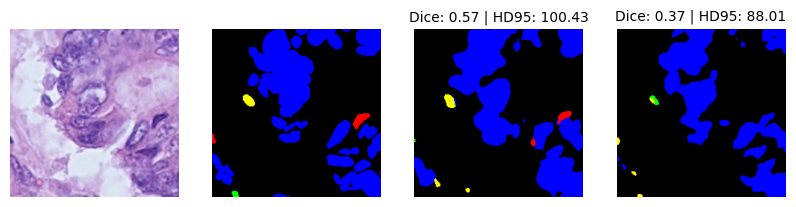

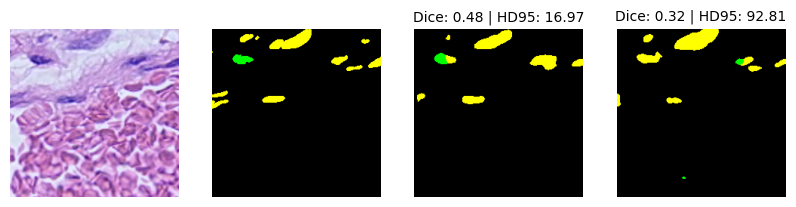

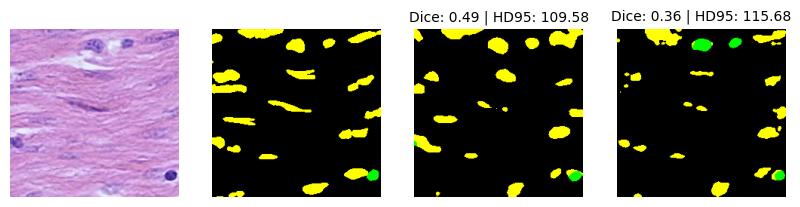

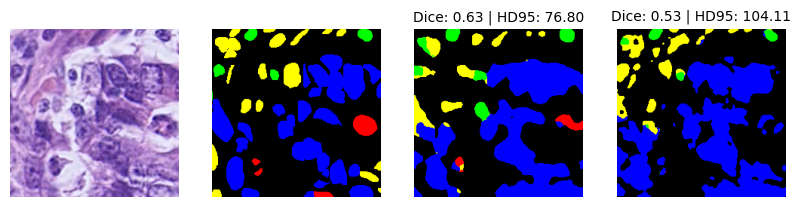

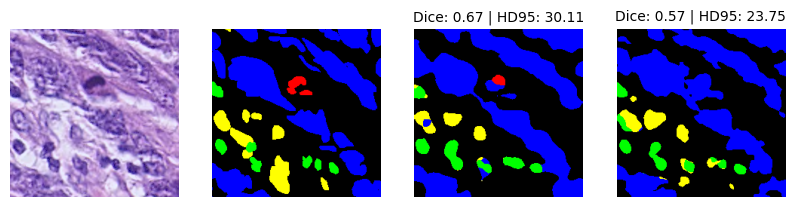

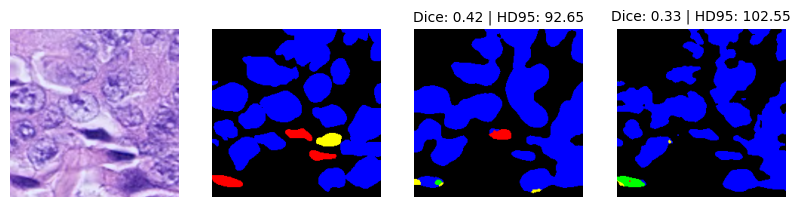

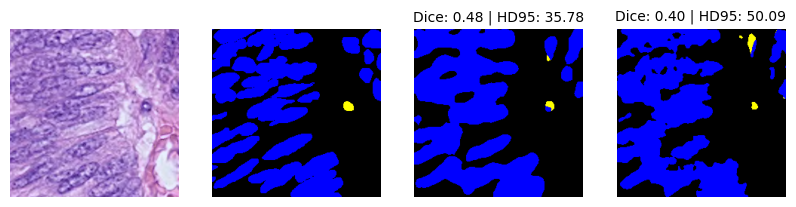

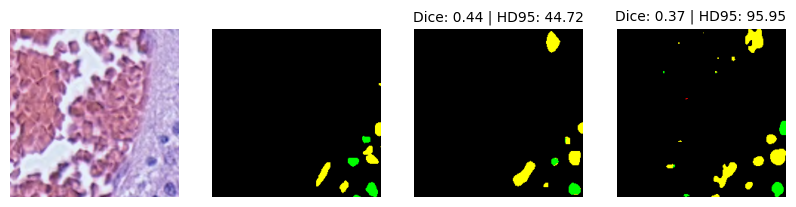

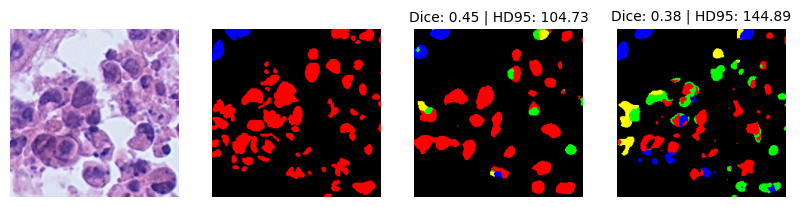

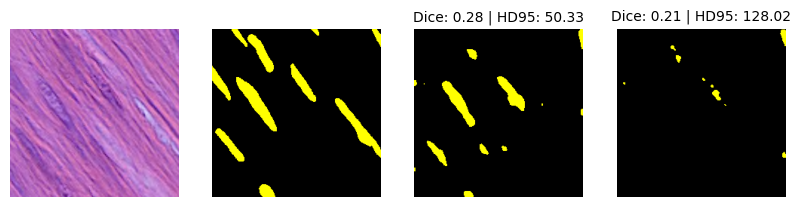

In [18]:
N_IMAGES = 10

for _, row in df_results.sort_values("Dice (diff)", ascending=False)[:N_IMAGES].iterrows():
    image, target, metadata = dataset[row["index"]]

    fig, ax = plt.subplots(1, 2 + len(MODELS), figsize=(10, 3))
    for j, model in enumerate(MODELS):
        prediction = model(image.unsqueeze(0), to_size=(224, 224))
        prediction = torch.argmax(prediction, dim=1)

        image_normalized = _preprocess_image(image.clone())
        image_with_mask = _overlay_mask(image_normalized, prediction.squeeze())

        fig.axes[0].imshow(image_normalized.permute(1, 2, 0))
        fig.axes[1].imshow(_draw_semantic_mask(target).permute(1, 2, 0))
        fig.axes[2+j].imshow(_draw_semantic_mask(prediction).permute(1, 2, 0))

        dice_value = dice_metric(_one_hot(prediction.squeeze()), _one_hot(target))
        hd95_value = monai_metrics.compute_hausdorff_distance(_one_hot(prediction.squeeze()).unsqueeze(0), _one_hot(target).unsqueeze(0), percentile=95)
        hd95_value = hd95_value.nanmean()

        fig.axes[2+j].set_title(f"Dice: {dice_value:.2f} | HD95: {hd95_value:.2f}", fontsize=10)

        for ax in fig.axes:
            ax.axis('off')

### Plot randomly sampled images

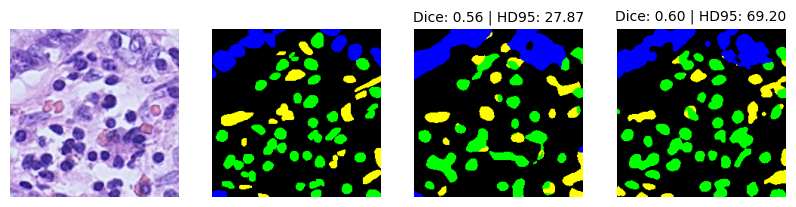

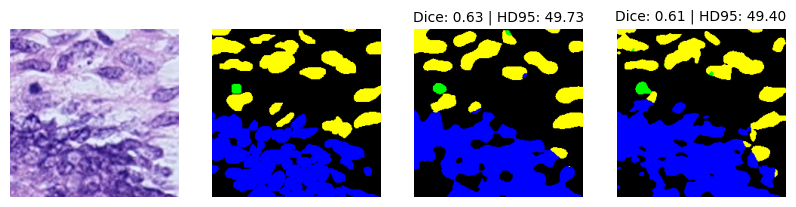

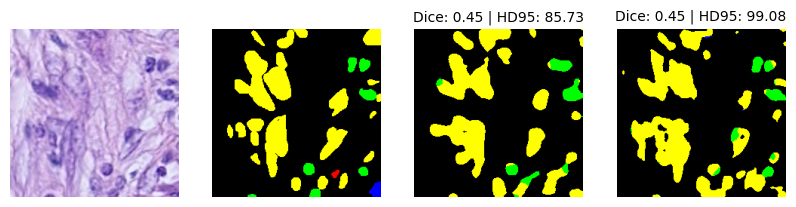

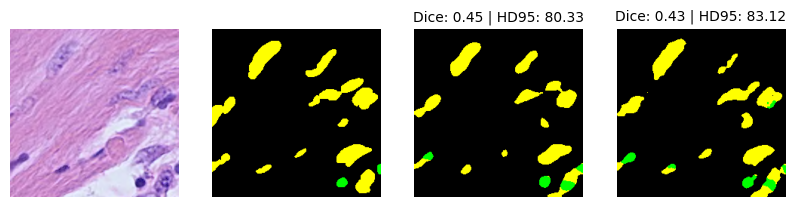

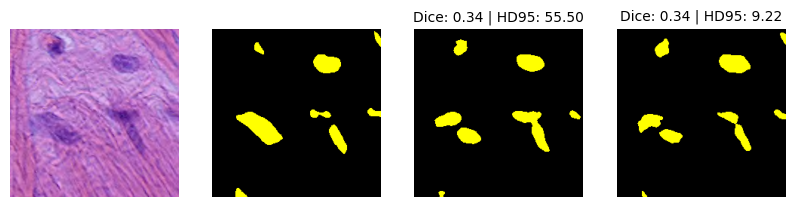

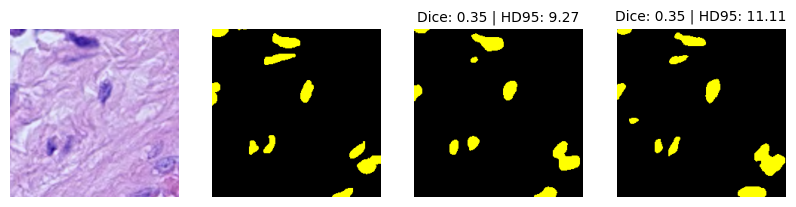

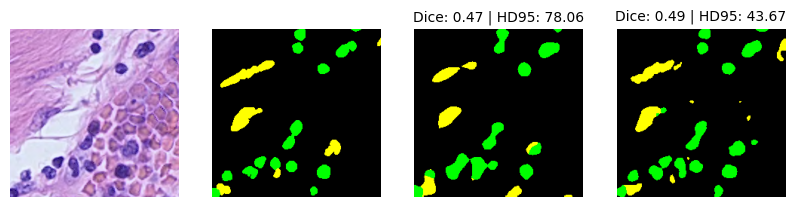

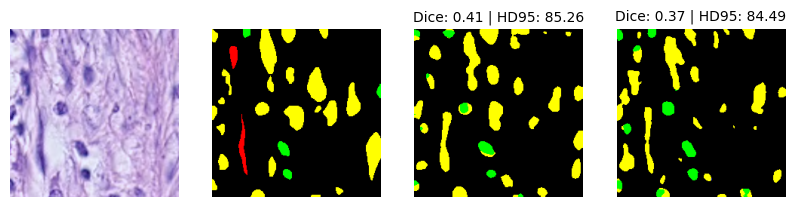

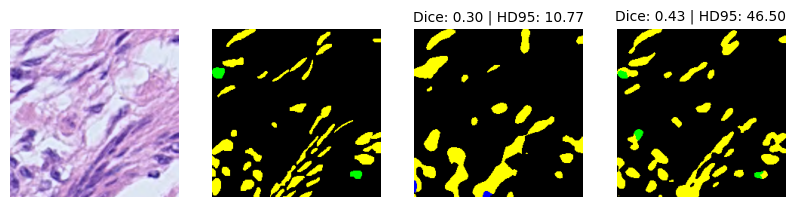

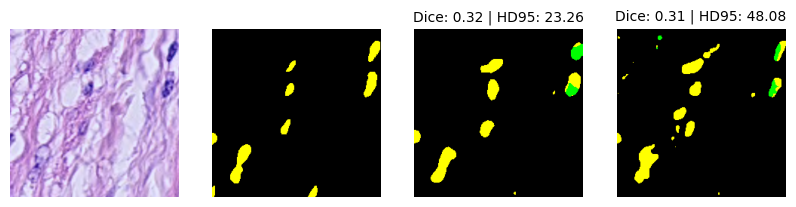

In [19]:
N_IMAGES = 10

for _, row in df_results.sample(N_IMAGES).iterrows():
    image, target, metadata = dataset[row["index"]]

    fig, ax = plt.subplots(1, 2 + len(MODELS), figsize=(10, 3))
    for j, model in enumerate(MODELS):
        prediction = model(image.unsqueeze(0), to_size=(224, 224))
        prediction = torch.argmax(prediction, dim=1)

        image_normalized = _preprocess_image(image.clone())
        image_with_mask = _overlay_mask(image_normalized, prediction.squeeze())

        fig.axes[0].imshow(image_normalized.permute(1, 2, 0))
        fig.axes[1].imshow(_draw_semantic_mask(target).permute(1, 2, 0))
        fig.axes[2+j].imshow(_draw_semantic_mask(prediction).permute(1, 2, 0))

        dice_value = dice_metric(_one_hot(prediction.squeeze()), _one_hot(target))
        hd95_value = monai_metrics.compute_hausdorff_distance(_one_hot(prediction.squeeze()).unsqueeze(0), _one_hot(target).unsqueeze(0), percentile=95)
        hd95_value = hd95_value.nanmean()

        fig.axes[2+j].set_title(f"Dice: {dice_value:.2f} | HD95: {hd95_value:.2f}", fontsize=10)

        for ax in fig.axes:
            ax.axis('off')